In [1]:
import tensorflow as tf
import numpy as np
import scipy
from scipy.io import loadmat

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import imageio
%matplotlib inline
import pdb

import os

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Constants

In [2]:
# Image dimensions constants. 
OUT_WIDTH = 700
OUT_HEIGHT = 500
OUT_CHANNELS = 3

In [2]:
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

## 2. Load VGG model. 

The first step is to load the VGG convolutional neural network as a native Tensorflow Model. 

In [4]:
VGG_PATH = "pretrained_models/imagenet-vgg-verydeep-19.mat"
# load the Pre-trained VGG weights
vgg = loadmat(VGG_PATH)
# isolate the layers - and not the metadata
layers = vgg['layers'][0]

Now, `layers` is an array, holding each of the weights for each layer as matrices. The order of the layers can be found [here](https://gist.github.com/ksimonyan/3785162f95cd2d5fee77#file-readme-md). 

To Load the VGG model as a Tensorflow model, I'll need to be do the following:

1. Load the weights for each model
2. Construct `tf.nn.conv2d` for each 2D convolutional layer - based on loaded weights
3. Apply th `relu` activation to each of these convolutional layers
4. Remove the max-pooling layers in the VGG network, and replace them with average-pooling layers
5. Omit the fully-connected layers in the VGG model. 

In [5]:
# encapsulate the functions needed to load the VGG model in a class
class VGGLoader:
    
    def __init__(self, vgg_path, out_height, out_width, out_channels):
        self.vgg_path = vgg_path
        self.out_height = out_height
        self.out_width = out_width
        self.out_channels = out_channels
        
    # load the model as a matrix
    # store the pre-trained weights as a class atribute
    def _load_layers(self):
        # load the VGG model
        vgg = loadmat(self.vgg_path)
        # return just the pre-trained weights
        self.layers =  vgg['layers'][0]
    
    # Load the weights of a given layer
    def _get_weights(self,layer):
        # load pre-trained weights and biases
        weight = self.layers[layer][0][0][2][0][0]
        bias = self.layers[layer][0][0][2][0][1]
        return weight, bias
    
    # create a tensorflow convolutional layer based on the pre-trained weights
    def _conv2d(self, prev_layer, layer):
    
        weight, bias = self._get_weights(layer)
        W = tf.constant(weight)
        b = tf.constant(np.reshape(bias, (bias.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
    
    # apply a relu activation onto a Conv2d Layer
    def _relu(self, conv2d_layer):
        return tf.nn.relu(conv2d_layer)
    
    # create a convolutional layer on the pretrained weights, then apply an activation
    def _conv2d_relu(self, prev_layer, layer):
        return self._relu(self._conv2d(prev_layer, layer))

    # create an average-pooling layer
    def _avgpool(self, prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    ########################################
    # Key method - Load and return the VGG model as a Tensorflow Model
    ########################################
    def get_model(self):
        # Load and save the pre-trained weights
        self._load_layers()
        
        # build up the sequential model
        model = {}
        model['input']   = tf.Variable(np.zeros((1, self.out_height, self.out_width, \
                                                 self.out_channels)), dtype = 'float32')
        model['conv1_1']  = self._conv2d_relu(model['input'], 0)
        model['conv1_2']  = self._conv2d_relu(model['conv1_1'], 2)
        model['avgpool1'] = self._avgpool(model['conv1_2'])
        model['conv2_1']  = self._conv2d_relu(model['avgpool1'], 5)
        model['conv2_2']  = self._conv2d_relu(model['conv2_1'], 7)
        model['avgpool2'] = self._avgpool(model['conv2_2'])
        model['conv3_1']  = self._conv2d_relu(model['avgpool2'], 10)
        model['conv3_2']  = self._conv2d_relu(model['conv3_1'], 12)
        model['conv3_3']  = self._conv2d_relu(model['conv3_2'], 14)
        model['conv3_4']  = self._conv2d_relu(model['conv3_3'], 16)
        model['avgpool3'] = self._avgpool(model['conv3_4'])
        model['conv4_1']  = self._conv2d_relu(model['avgpool3'], 19)
        model['conv4_2']  = self._conv2d_relu(model['conv4_1'], 21)
        model['conv4_3']  = self._conv2d_relu(model['conv4_2'], 23)
        model['conv4_4']  = self._conv2d_relu(model['conv4_3'], 25)
        model['avgpool4'] = self._avgpool(model['conv4_4'])
        model['conv5_1']  = self._conv2d_relu(model['avgpool4'], 28)
        model['conv5_2']  = self._conv2d_relu(model['conv5_1'], 30)
        model['conv5_3']  = self._conv2d_relu(model['conv5_2'], 32)
        model['conv5_4']  = self._conv2d_relu(model['conv5_3'], 34)
        model['avgpool5'] = self._avgpool(model['conv5_4'])
        return model

In [5]:
loader = VGGLoader(out_channels=OUT_CHANNELS, out_height=OUT_HEIGHT, out_width= OUT_WIDTH, vgg_path= VGG_PATH)

In [6]:
model = loader.get_model()

In [7]:
model

{'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 250, 350, 64) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 125, 175, 128) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 63, 88, 256) dtype=float32>,
 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 32, 44, 512) dtype=float32>,
 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 16, 22, 512) dtype=float32>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 500, 700, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 500, 700, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 250, 350, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 250, 350, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 125, 175, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 125, 175, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 125, 175, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 125, 175, 256) dtype=float32>,
 'conv4_1': <tf.Te

In [8]:
model['input']

<tf.Variable 'Variable:0' shape=(1, 500, 700, 3) dtype=float32_ref>

## 3. Define the Content and Style loss functions

To transfer the artistic style from one paining to another, two tradeoffs must be kept. First, we must preserve enough of the *content* of the original image so that we can distinguish the original features. On the other hand, we must distort the picture enough so that the transfered style is visible. 

This tradeoff is encapsulated in two loss functions, as described by Gatys et al. The first $L_{content}$, captures the difference of the content of the composed image and the original image, and the second, $L_{style}$, captures the difference in "style" of the style image and the composed image. 


##### Content loss

Let $\overrightarrow{p}$ be the content image, and $\overrightarrow{x}$ be the composed image. At every layer $l$ of the neural network, an image is mapped to a filter $F^l$, where $F^l_{i,j}$ is the activation of the $i^{th}$ filter at the $j^{th}$ position at layer $l$. 

Let $P^l$ and $F^l$ be the feature representations of $\overrightarrow{p}$ and $\overrightarrow{x}$ at layer $l$, respectively

A natural loss function for the content deviation at layer $l$ is:

$$
L_{content}(\overrightarrow{p}, \overrightarrow{x}, l) = \frac{1}{2} \sum_{i}{\sum_{j}{(F^l_{i,j} - P^l_{i,j})^2}}
$$

The derivative of this loss function is:

$$
\frac{\partial L_{content}}{\partial F^l_{ij}} = \begin{equation}
  X = \left \{
  \begin{aligned}
    &F^l_{ij} - P^l_{ij}, && \text{if}\ F^l_{ij} > 0 \\
    &0, && \text{otherwise}
  \end{aligned} \right.
\end{equation} 
$$


#####  Style loss

To capture the "style" of an image at layer $l$, Gatys et al use the the Gram matrix $G^l$ of the feature representation $F^l$:

$$
G^l_{i,j} = \sum_k{F^l_{i,k}F^l_{j,k}}
$$

The Gram matrix is the matrix populated by the inner product of the different filter responses at layer $l$. The element $G^l_{i,j}$ is an approximation of the correlation between filter responses $i$ and $j$ at the $l^{th}$ layer. The idea is that two images should have similar styles if their Gram matrices at each layer are similar, as their feature representations are correlated in a similar manner.

Therefore, if $G^l$ and $A^l$ be the Gram matrices of $\overrightarrow{p}$ and $\overrightarrow{x}$ at layer $l$, respectively, the contribution to the style loss at that layer is:

$$
L_{style}(l) = \frac{1}{c}\sum_i{\sum_j{G^l_{i,j} - A^l_{i,j})^2}}
$$

Where c is a normalizing constant, and so the total loss is:

$$
\sum_l{w_lL_{style}(l)}
$$

Where $w_i \quad i = 1, 2, ...$ are weights to give to the different layers.

### 3. Misc Functions

In [6]:
def generate_noise_image(content_image, noise_ratio):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, OUT_HEIGHT,OUT_WIDTH, OUT_CHANNELS)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def load_image(path):
    image = Image.open(path)
    # resize image to inputted size
    image = image.resize((OUT_WIDTH, OUT_HEIGHT))
    # reshape image to appropriate 
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image_data = np.array(image.getdata()).reshape(( OUT_HEIGHT, OUT_WIDTH, OUT_CHANNELS))
    image_data= np.reshape(image_data, ((1,) + image_data.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image_data = image_data - MEAN_VALUES
    return image, image_data, 

def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    imageio.imwrite(path, image)

In [66]:
CONTENT_IMAGE = "images/birds.jpg"
STYLE_IMAGE = "images/picasso_women.jpg"

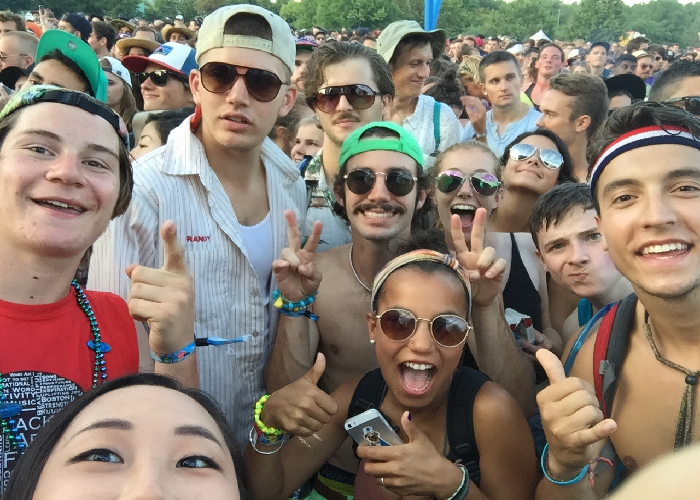

In [78]:
content_image, content_data = load_image(CONTENT_IMAGE)
content_image

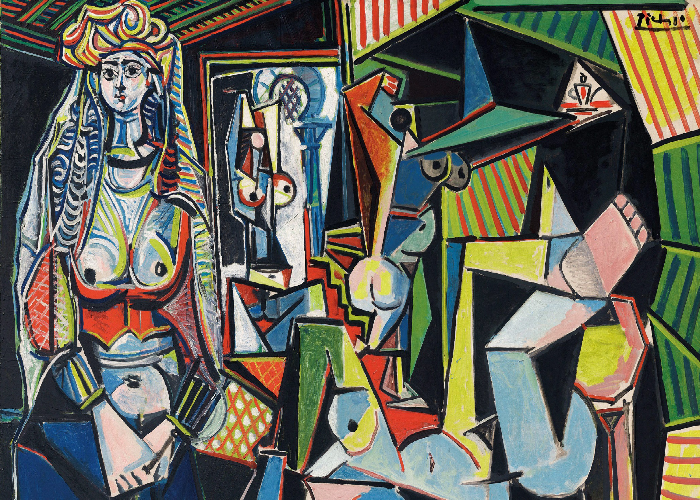

In [79]:
style_image, style_data = load_image(STYLE_IMAGE)
style_image

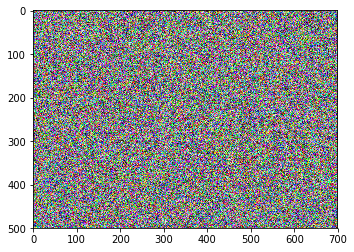

In [80]:
# Generate the white noise and content presentation mixed image
# which will be the basis for the algorithm to "paint".
input_image = generate_noise_image(content_data, .6)
imshow(input_image[0])

In [81]:
loader = VGGLoader(out_channels=OUT_CHANNELS, out_height=OUT_HEIGHT, out_width= OUT_WIDTH, vgg_path= VGG_PATH)

In [82]:
model = loader.get_model()

In [7]:
def content_layer_loss(p, x):
    _, h, w, d = [i.value for i in p.get_shape()]    # d: number of filters; h,w : height, width
    M = h * w 
    N = d 
    K = 1. / (2. * N**0.5 * M**0.5)
    loss = K * tf.reduce_sum(tf.pow((x - p), 2))
    return loss


### STYLE LOSS: FUNCTION TO CALCULATE AND INSTANTIATION

def style_layer_loss(a, x):
    _, h, w, d = [i.value for i in a.get_shape()]
    M = h * w 
    N = d 
    A = gram_matrix(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

def gram_matrix(x, M, N):
    F = tf.reshape(x, (M, N))                   
    G = tf.matmul(tf.transpose(F), F)
    return G


In [84]:
with tf.Session() as sess:
    sess.run(model['input'].assign(content_data))
    p = sess.run(model['conv4_2'])  # Get activation output for content layer
    x = model['conv4_2']
    p = tf.convert_to_tensor(p)
    content_loss = content_layer_loss(p, x) 

In [85]:
layer_weights  = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
    ]

with tf.Session() as sess:
    sess.run(model['input'].assign(style_data))
    style_loss = 0.
    # style loss is calculated for each style layer and summed
    for layer, weight in layer_weights:
        a = sess.run(model[layer])
        x = model[layer]
        a = tf.convert_to_tensor(a)
        style_loss += style_layer_loss(a, x)

In [86]:
# Constant to put more emphasis on content loss.
BETA = 5
# Constant to put more emphasis on style loss.
ALPHA = 100

with tf.Session() as sess:
    # loss function
    L_total  = BETA * content_loss + ALPHA * style_loss 
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(L_total)
    
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    sess.run(model['input'].assign(input_image))
    for i in range(2001):
        # run optimisation
        sess.run(train_step)
        
        
        if i%20 == 0:
            mixed_image = sess.run(model['input'])
            print('Iteration %d' % (i))
            print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
            print('cost: ', sess.run(L_total))

            if not os.path.exists("output"):
                os.mkdir("output")

            filename = 'output/%d.png' % (i)
            save_image(filename, mixed_image)
    

Iteration 0
('sum : ', 4224622.0)
('cost: ', 218311950000.0)
Iteration 20
('sum : ', 3839685.8)
('cost: ', 33699342000.0)
Iteration 40
('sum : ', 3288423.5)
('cost: ', 12873375000.0)
Iteration 60
('sum : ', 2712509.0)
('cost: ', 7007603000.0)
Iteration 80
('sum : ', 2214420.0)
('cost: ', 4692084000.0)
Iteration 100
('sum : ', 1837290.5)
('cost: ', 3554788400.0)
Iteration 120
('sum : ', 1517006.2)
('cost: ', 2899004400.0)
Iteration 140
('sum : ', 1220178.0)
('cost: ', 2478145500.0)
Iteration 160
('sum : ', 939102.0)
('cost: ', 2184167400.0)
Iteration 180
('sum : ', 670885.75)
('cost: ', 1965825300.0)
Iteration 200
('sum : ', 413234.25)
('cost: ', 1796297200.0)
Iteration 220
('sum : ', 164942.75)
('cost: ', 1658803300.0)
Iteration 240
('sum : ', -74621.5)
('cost: ', 1544432600.0)
Iteration 260
('sum : ', -306413.75)
('cost: ', 1447530500.0)
Iteration 280
('sum : ', -530610.75)
('cost: ', 1364167800.0)
Iteration 300
('sum : ', -748290.25)
('cost: ', 1291752400.0)
Iteration 320
('sum : ', 

KeyboardInterrupt: 

Now, showing the result after ~1200 epochs. I renamed the folder `ouptut` to `output2`

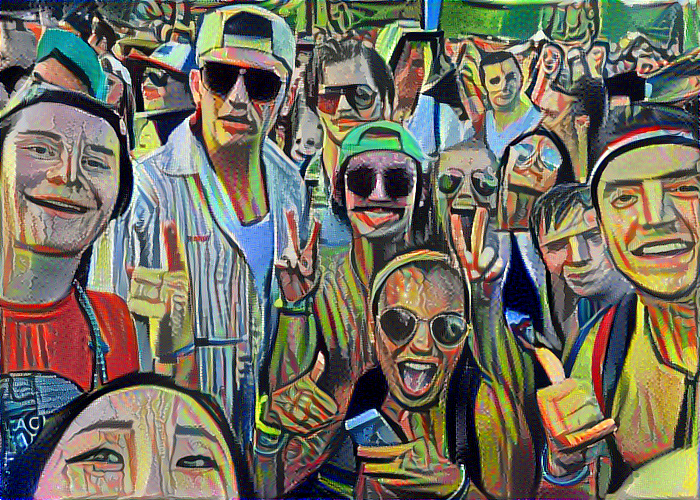

In [87]:
Image.open("./output/1280.png")

Pretty sweet. 

One more:

---



In [19]:
CONTENT_IMAGE = "images/eli.jpg"
STYLE_IMAGE = "images/squares.jpg"

In [20]:
OUT_WIDTH = 500
OUT_HEIGHT = 500
OUT_CHANNELS = 3

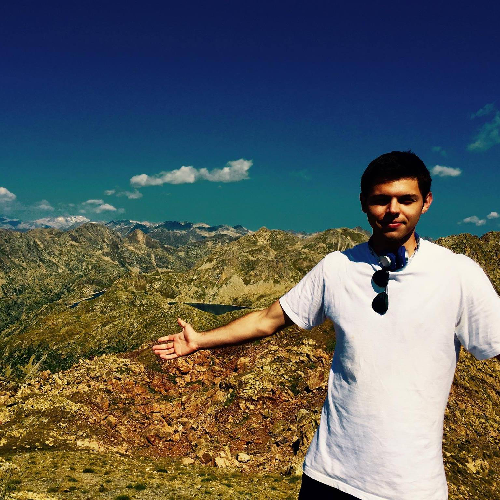

In [21]:
content_image, content_data = load_image(CONTENT_IMAGE)
content_image

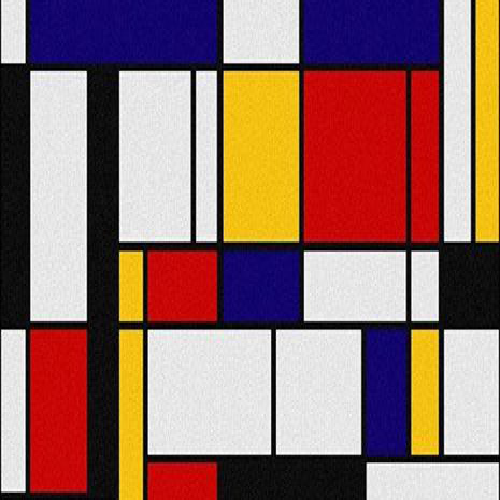

In [22]:
style_image, style_data = load_image(STYLE_IMAGE)
style_image

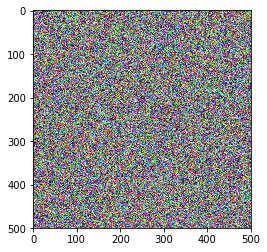

In [23]:
# Generate the white noise and content presentation mixed image
# which will be the basis for the algorithm to "paint".
input_image = generate_noise_image(content_data, .6)
imshow(input_image[0])

In [26]:
loader = VGGLoader(out_channels=OUT_CHANNELS, out_height=OUT_HEIGHT, out_width= OUT_WIDTH, vgg_path= VGG_PATH)

In [27]:
model = loader.get_model()

In [28]:
with tf.Session() as sess:
    sess.run(model['input'].assign(content_data))
    p = sess.run(model['conv4_2'])  # Get activation output for content layer
    x = model['conv4_2']
    p = tf.convert_to_tensor(p)
    content_loss = content_layer_loss(p, x) 

In [29]:
layer_weights  = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
    ]

with tf.Session() as sess:
    sess.run(model['input'].assign(style_data))
    style_loss = 0.
    # style loss is calculated for each style layer and summed
    for layer, weight in layer_weights:
        a = sess.run(model[layer])
        x = model[layer]
        a = tf.convert_to_tensor(a)
        style_loss += style_layer_loss(a, x)

In [30]:
# Constant to put more emphasis on content loss.
BETA = 5
# Constant to put more emphasis on style loss.
ALPHA = 100

with tf.Session() as sess:
    # loss function
    L_total  = BETA * content_loss + ALPHA * style_loss 
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(L_total)
    
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    sess.run(model['input'].assign(input_image))
    for i in range(2001):
        # run optimisation
        sess.run(train_step)
        
        
        if i%20 == 0:
            mixed_image = sess.run(model['input'])
            print('Iteration %d' % (i))
            print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
            print('cost: ', sess.run(L_total))

            if not os.path.exists("output"):
                os.mkdir("output")

            filename = 'output/%d.png' % (i)
            save_image(filename, mixed_image)
    

Iteration 0
('sum : ', -6887932.5)
('cost: ', 685725060000.0)
Iteration 20
('sum : ', -7840895.5)
('cost: ', 212364570000.0)


KeyboardInterrupt: 